In [1]:
from spectral_cube import SpectralCube
from pvextractor import extract_pv_slice, Path
import pylab as pl
import numpy as np
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import wcs
from matplotlib.colors import LogNorm
from astropy.visualization.stretch import SinhStretch
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
from astropy.utils import data
#from cycler import cycler
#from itertools import cycle
from scipy.stats import ks_2samp
from scipy.optimize import fsolve
from spectral_cube import Projection
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from scipy.interpolate import interp1d
from astropy.convolution import Gaussian1DKernel

fatal: detected dubious ownership in repository at '/blue/adamginsburg/adamginsburg/repos/dask'
To add an exception for this directory, call:

	git config --global --add safe.directory /blue/adamginsburg/adamginsburg/repos/dask


# Downsampling

## Data

In [2]:
a_fixednames =['/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.12CO.spw17.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.Ha.spw19.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.CH3OH.spw21.fits',
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.H2CO.spw23.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.H2CO.spw25.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.SiO.spw27.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.13CO.spw29.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.C18O.spw31.fits' 
               ]
cube_17 = SpectralCube.read(a_fixednames[0]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_21 = SpectralCube.read(a_fixednames[2]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_23 = SpectralCube.read(a_fixednames[3]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_25 = SpectralCube.read(a_fixednames[4]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_27 = SpectralCube.read(a_fixednames[5]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_29 = SpectralCube.read(a_fixednames[6]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_31 = SpectralCube.read(a_fixednames[7]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')


In [3]:
cube_29.beam

Beam: BMAJ=29.5389320000004 arcsec BMIN=29.5389320000004 arcsec BPA=60.120503 deg

In [4]:
def noise_mask(cube, vmin, vmax, level):
    noise = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(vmin, vmax).std(axis=0)
    peak = cube.max(axis=0)
    spatial_mask = peak > level * noise
    return spatial_mask

def noise_mask_slab(cube, vmin, vmax, level, cut1, cut2):
    noise = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio').spectral_slab(vmin, vmax).std(axis=0)
    peak = cube.spectral_slab(cut1, cut2).max(axis=0)
    spatial_mask = peak > level * noise
    return spatial_mask

In [5]:
mask_17 = noise_mask(cube_17, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_29 = noise_mask(cube_29, -100*u.km/u.second, -50 *u.km/u.second, 5)
mask_31 = noise_mask(cube_31, -100*u.km/u.second, -50 *u.km/u.second, 5)

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out

In [6]:
#interp_cube17 = cube_17.spectral_interpolate(cube_29.spectral_axis)
#reproj_cube17 = interp_cube17.reproject(cube_29.header)

## Down Sampling

In [7]:
fwhm_factor = np.sqrt(8*np.log(2))
current_resolution = 0.159 * u.km/u.s
target_resolution = 2 * u.km/u.s
pixel_scale = 0.159 * u.km/u.s
gaussian_width = ((target_resolution**2 - current_resolution**2)**0.5 /
                  pixel_scale / fwhm_factor)
kernel = Gaussian1DKernel(gaussian_width.value)
new_cube_17 = cube_17.spectral_smooth(kernel)

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.131e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.091e+01 [aplpy.core]


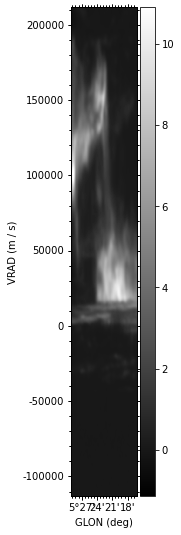

In [8]:
new_cube_17.mean(axis=1).quicklook()

In [9]:
fwhm_factor = np.sqrt(8*np.log(2))
current_resolution = 0.332 * u.km/u.s
target_resolution = 2 * u.km/u.s
pixel_scale = 0.332 * u.km/u.s
gaussian_width = ((target_resolution**2 - current_resolution**2)**0.5 /
                  pixel_scale / fwhm_factor)
kernel = Gaussian1DKernel(gaussian_width.value)
new_cube_29 = cube_29.spectral_smooth(kernel)

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.222e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.032e+00 [aplpy.core]


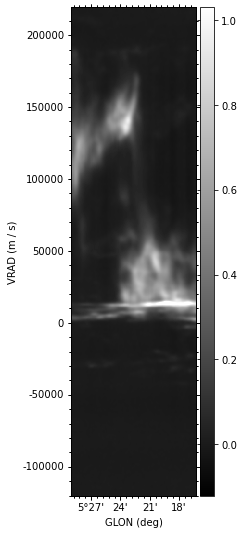

In [10]:
new_cube_29.mean(axis=1).quicklook()

In [11]:
#new_cube_17.spectral_extrema
new_axis = np.arange(new_cube_17.spectral_extrema[0].value,new_cube_17.spectral_extrema[1].value,2)*u.km/u.s
new_axis

<Quantity [-112.76827599, -110.76827599, -108.76827599, -106.76827599,
           -104.76827599, -102.76827599, -100.76827599,  -98.76827599,
            -96.76827599,  -94.76827599,  -92.76827599,  -90.76827599,
            -88.76827599,  -86.76827599,  -84.76827599,  -82.76827599,
            -80.76827599,  -78.76827599,  -76.76827599,  -74.76827599,
            -72.76827599,  -70.76827599,  -68.76827599,  -66.76827599,
            -64.76827599,  -62.76827599,  -60.76827599,  -58.76827599,
            -56.76827599,  -54.76827599,  -52.76827599,  -50.76827599,
            -48.76827599,  -46.76827599,  -44.76827599,  -42.76827599,
            -40.76827599,  -38.76827599,  -36.76827599,  -34.76827599,
            -32.76827599,  -30.76827599,  -28.76827599,  -26.76827599,
            -24.76827599,  -22.76827599,  -20.76827599,  -18.76827599,
            -16.76827599,  -14.76827599,  -12.76827599,  -10.76827599,
             -8.76827599,   -6.76827599,   -4.76827599,   -2.76827599,
      

In [12]:
spec_cube_17 = new_cube_17.spectral_interpolate(new_axis,
                                          suppress_smooth_warning=True)

In [13]:
spec_cube_29 = new_cube_29.spectral_interpolate(new_axis,
                                          suppress_smooth_warning=True)

In [14]:
spec_cube_29.spectral_slab(-100*u.km/u.second, -50*u.km/u.second).max()#*5#.mean(axis=1).quicklook()

<Quantity 0.02378478 K>

In [15]:
spec_cube_17.shape

(163, 63, 274)

In [16]:
spec_cube_29.shape

(163, 61, 262)

In [17]:
#interp_cube17 = new_cube_17.spectral_interpolate(new_cube_29.spectral_axis)
reproj_cube17 = spec_cube_17.reproject(spec_cube_29.header)

In [18]:
mas_29_1 = spec_cube_29 > 5*0.01*u.K#5 * 0.001*u.K
mas_17_1 = reproj_cube17 > 40*0.01*u.K#40*5 * 0.0003*u.K

In [19]:
mas_29_1.shape

(163, 61, 262)

In [20]:
spec_cube_29.shape

(163, 61, 262)

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -5.742e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.247e+00 [aplpy.core]


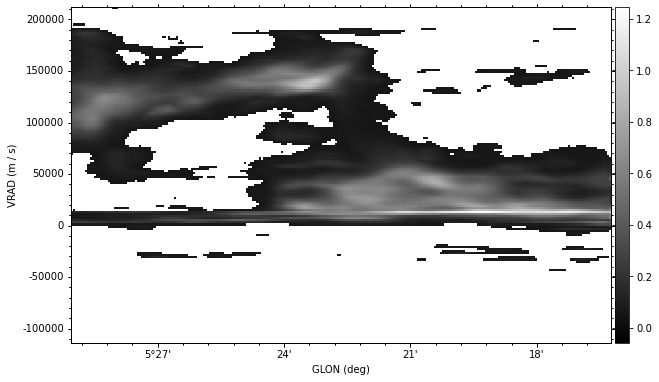

In [21]:
spec_cube_29.with_mask(mas_29_1).mean(axis=1).quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -5.705e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.122e+01 [aplpy.core]


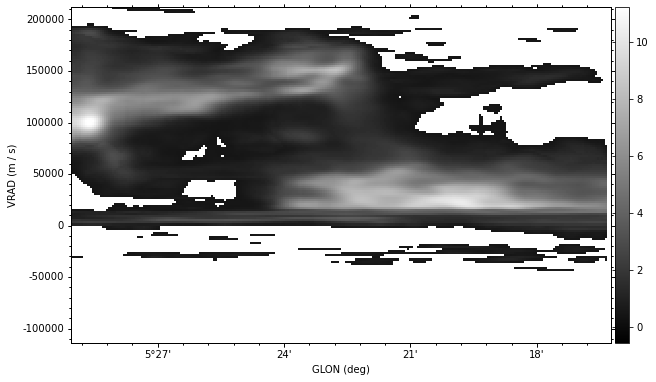

In [22]:
reproj_cube17.with_mask(mas_17_1).mean(axis=1).quicklook()

In [23]:
cu_29 = (spec_cube_29.with_mask(mas_29_1).with_mask(mas_17_1)).flattened()
cu_17 = (reproj_cube17.with_mask(mas_17_1).with_mask(mas_29_1)).flattened()

In [24]:
def y(x, ratio):
    return 1/ratio*x
x = np.linspace(0, 16, num=50)
y_rat = y(x, 40)

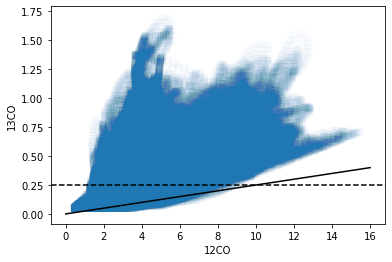

In [25]:
# color code with regions? velocity brigd, G5a, G5b, line of sight
plt.scatter(cu_17, cu_29, marker=',', alpha=0.01)
plt.xlabel('12CO')
plt.ylabel('13CO')
#plt.ylim(0, 0.25)
plt.axhline(5*0.05, color='k', linestyle='--')
plt.plot(x, y_rat, color='k')

## Markup

In [26]:
def plot_pv(t_pv):
    fig = plt.figure(figsize=(6,6))
    ax = pl.subplot(111, projection=wcs.WCS(t_pv.header))
    im = ax.imshow(t_pv.data)
    ax0 = ax.coords[0]
    ax0.set_format_unit(u.arcmin)
    ax1 = ax.coords[1]
    ax1.set_format_unit(u.km/u.s)
    ax.set_ylabel("Velocity [km/s]")
    #ax.set_xlabel("Offset in Longtitude from $\ell=5.48^{\circ}$ [arcmin]")
    ax.set_xlabel("Offset in Longtitude from $\ell=5.48^{\circ}$ [arcmin]")
    ax.set_aspect(2)
    cb = pl.colorbar(mappable=im)
    ax.set_ylim(top=t_pv.data.shape[0], bottom=0)

In [27]:
def cross_product(xA, yA, x1, y1, x2, y2): 
    v1 = (x2-x1, y2-y1)   # Vector 1
    v2 = (x2-xA, y2-yA)   # Vector 2
    xp = v1[0]*v2[1] - v1[1]*v2[0]  # Cross product
    above = False
    if xp < 0:
        above = True
        #print('on one side')
    return above
def get_y(x, p1x, p1y, p2x, p2y):
    return (p1y - p2y)/(p1x - p2x)*x + p1y - p1x*(p1y - p2y)/(p1x - p2x)

In [28]:
t_pv = spec_cube_29.with_mask(mas_29_1).mean(axis=1)
#t_pv[t_pv>30] = 0

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,


In [29]:
x = np.arange(t_pv.data.shape[1])
y1 = get_y(x, 0, 410, 5, 410)/6.3
y2 = get_y(x, 0, 600, 50, 650)/6.3
y3 = get_y(x, 80, 400, 80.001, 500)/6.3
y4 = get_y(x, 0, 600, 5, 600)/6.3
y5 = get_y(x, 170, 600, 150, 750)/6.3
y6 = get_y(x, 125, 600, 120, 750)/6.3

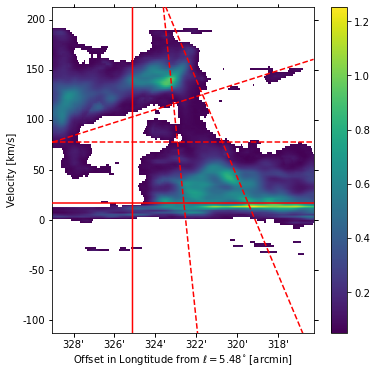

In [30]:
plot_pv(t_pv)
plt.plot(x, y1, color='red')
plt.plot(x, y2, color='red', linestyle='dashed')
plt.plot(x, y3, color='red')
plt.plot(x, y4, color='red', linestyle='dashed')
plt.plot(x, y5, color='red', linestyle='dashed')
plt.plot(x, y6, color='red', linestyle='dashed')
#plt.scatter(125, 600, color='magenta')
#plt.scatter(120, 750, color='magenta')

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.093e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.831e+00 [aplpy.core]


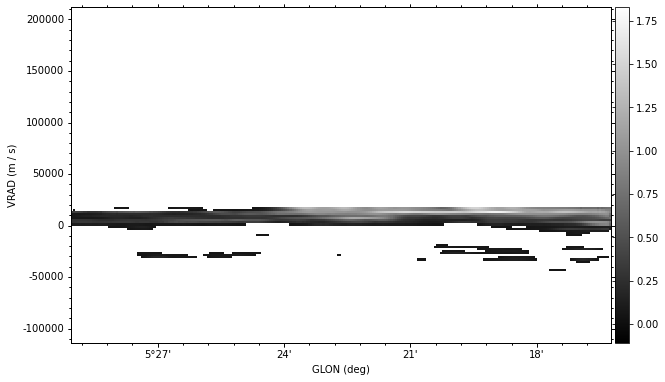

In [31]:
mask_sightline = np.copy(t_pv.mask.include())
for yA in range(mask_sightline.shape[0]):
    for xA in range(mask_sightline.shape[1]):
        check1 = cross_product(xA, yA, 0, 410/6.3, 5, 410/6.3)
        #check2 = cross_product(xA, yA, 85, 460, 75, 700)
        #check3 = cross_product(xA, yA, 75, 700, 40, 600)
        #check4 = cross_product(xA, yA, 40, 600, 55, 350)
        mask_sightline[yA, xA] = not check1# and check2 and check3 and check4
#fig = plt.figure(figsize=(6,6))
#ax = pl.subplot(111, projection=wcs.WCS(t_pv.header))
#plt.imshow(mask_sightline)
spec_cube_29.with_mask(mas_29_1).with_mask(mask_sightline[:, None, :]).max(axis=1).quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -8.884e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.607e+00 [aplpy.core]


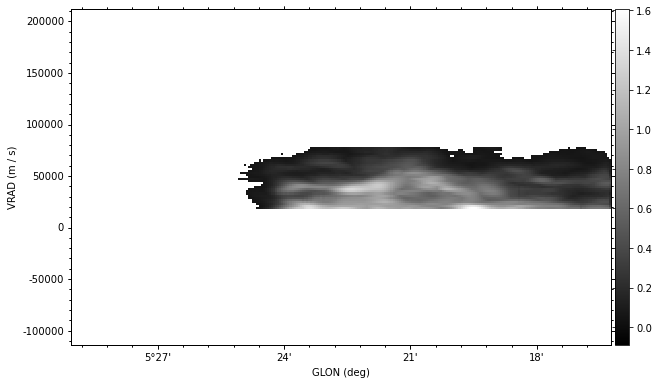

In [32]:
mask_G5b = np.copy(t_pv.mask.include())
for yA in range(mask_sightline.shape[0]):
    for xA in range(mask_sightline.shape[1]):
        check1 = cross_product(xA, yA, 0, 410/6.3, 5, 410/6.3)
        check2 = cross_product(xA, yA, 0, 600/6.3, 5, 600/6.3)
        check3 = cross_product(xA, yA, 80, 400/6.3, 80.001, 500/6.3)
        #check4 = cross_product(xA, yA, 40, 600, 55, 350)
        mask_G5b[yA, xA] = check1 and not check2 and not check3 #and check4
#fig = plt.figure(figsize=(6,6))
#ax = pl.subplot(111, projection=wcs.WCS(t_pv.header))
#plt.imshow(mask_sightline)
spec_cube_29.with_mask(mas_29_1).with_mask(mask_G5b[:, None, :]).max(axis=1).quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -6.009e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.274e+00 [aplpy.core]


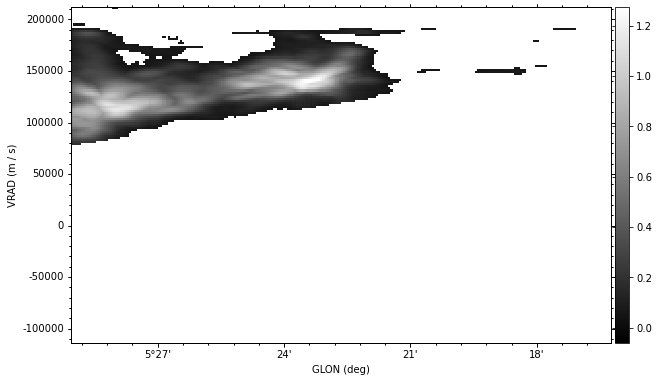

In [33]:
mask_G5a = np.copy(t_pv.mask.include())
for yA in range(mask_sightline.shape[0]):
    for xA in range(mask_sightline.shape[1]):
        check1 = cross_product(xA, yA, 0, 600/6.3, 50, 650/6.3)
        #check2 = cross_product(xA, yA, 85, 460, 75, 700)
        #check3 = cross_product(xA, yA, 75, 700, 40, 600)
        #check4 = cross_product(xA, yA, 40, 600, 55, 350)
        mask_G5a[yA, xA] = check1# and check2 and check3 and check4
#fig = plt.figure(figsize=(6,6))
#ax = pl.subplot(111, projection=wcs.WCS(t_pv.header))
#plt.imshow(mask_sightline)
spec_cube_29.with_mask(mas_29_1).with_mask(mask_G5a[:, None, :]).max(axis=1).quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to  3.608e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.104e-01 [aplpy.core]


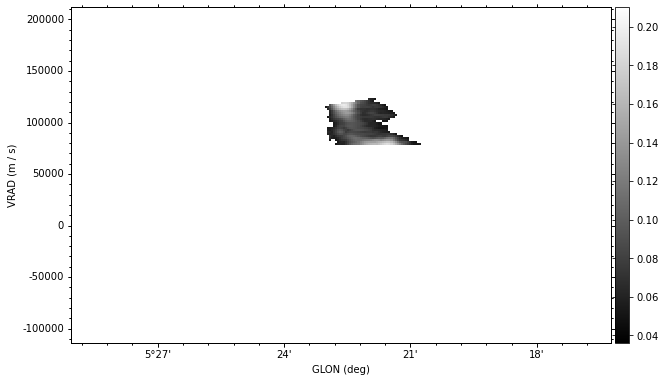

In [34]:
mask_bridge = np.copy(t_pv.mask.include())
for yA in range(mask_sightline.shape[0]):
    for xA in range(mask_sightline.shape[1]):
        check1 = cross_product(xA, yA, 0, 600/6.3, 50, 650/6.3)
        check2 = cross_product(xA, yA, 0, 600/6.3, 5, 600/6.3)
        check3 = cross_product(xA, yA, 170, 600/6.3, 150, 750/6.3)
        check4 = cross_product(xA, yA, 125, 600/6.3, 120, 750/6.3)
        mask_bridge[yA, xA] = not check1 and check2 and check3 and not check4
#fig = plt.figure(figsize=(6,6))
#ax = pl.subplot(111, projection=wcs.WCS(t_pv.header))
#plt.imshow(mask_sightline)
spec_cube_29.with_mask(mas_29_1).with_mask(mask_bridge[:, None, :]).max(axis=1).quicklook()

In [35]:
cu_29_LOS = spec_cube_29.with_mask(mas_29_1).with_mask(mas_17_1).with_mask(mask_sightline[:, None, :]).flattened()
cu_29_G5b = spec_cube_29.with_mask(mas_29_1).with_mask(mas_17_1).with_mask(mask_G5b[:, None, :]).flattened()
cu_29_G5a = spec_cube_29.with_mask(mas_29_1).with_mask(mas_17_1).with_mask(mask_G5a[:, None, :]).flattened()
cu_29_bridge = spec_cube_29.with_mask(mas_29_1).with_mask(mas_17_1).with_mask(mask_bridge[:, None, :]).flattened()

cu_17_LOS = reproj_cube17.with_mask(mas_17_1).with_mask(mas_29_1).with_mask(mask_sightline[:, None, :]).flattened()
cu_17_G5b = reproj_cube17.with_mask(mas_17_1).with_mask(mas_29_1).with_mask(mask_G5b[:, None, :]).flattened()
cu_17_G5a = reproj_cube17.with_mask(mas_17_1).with_mask(mas_29_1).with_mask(mask_G5a[:, None, :]).flattened()
cu_17_bridge = reproj_cube17.with_mask(mas_17_1).with_mask(mas_29_1).with_mask(mask_bridge[:, None, :]).flattened()

In [36]:
cu_29_LOS.shape

(119985,)

In [37]:
cu_17_LOS.shape

(119985,)

In [38]:
x = np.linspace(0, 16, num=50)
y_rat_2 = y(x, 40)
y_rat_3 = y(x, 25)
y_rat_4 = y(x, 53)

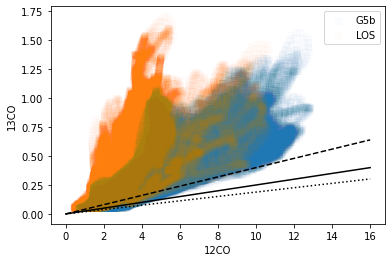

In [39]:
# color code with regions? velocity brigd, G5a, G5b, line of sight
plt.scatter(cu_17_G5b, cu_29_G5b, marker=',', alpha=0.01, label='G5b')
#plt.scatter(cu_17_G5a, cu_29_G5a, marker=',', alpha=0.01, label='G5a')
#plt.scatter(cu_17_bridge, cu_29_bridge, marker=',', alpha=0.01, label='BDG')
plt.scatter(cu_17_LOS, cu_29_LOS, marker=',', alpha=0.01, label='LOS')

plt.xlabel('12CO')
plt.ylabel('13CO')
#plt.ylim(0, 0.25)
plt.plot(x, y_rat_2, color='k', linestyle='solid')
plt.plot(x, y_rat_3, color='k', linestyle='dashed')
plt.plot(x, y_rat_4, color='k', linestyle='dotted')

plt.legend()

Text(0.5, 0.01, '$^{12}$CO [K]')

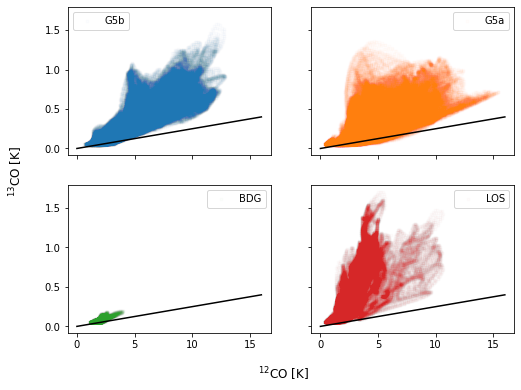

In [40]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(8,6)
axes[0,0].scatter(cu_17_G5b, cu_29_G5b, marker='.', alpha=0.01, label='G5b', color='tab:blue')
axes[0,1].scatter(cu_17_G5a, cu_29_G5a, marker='.', alpha=0.01, label='G5a', color='tab:orange')
axes[1,0].scatter(cu_17_bridge, cu_29_bridge, marker='.', alpha=0.01, label='BDG', color='tab:green')
axes[1,1].scatter(cu_17_LOS, cu_29_LOS, marker='.', alpha=0.01, label='LOS', color='tab:red')

for ax in axes.flatten():
    ax.legend()
    ax.plot(x, y_rat_2, color='k', linestyle='solid')

#plt.ylim(top=0.2)
#plt.xlim(right=6)
fig.supylabel('$^{13}$CO [K]')
fig.supxlabel('$^{12}$CO [K]')

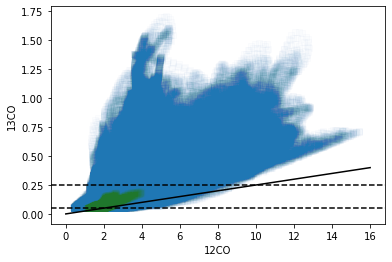

In [41]:
# color code with regions? velocity brigd, G5a, G5b, line of sight
plt.scatter(cu_17, cu_29, marker=',', alpha=0.01)
plt.scatter(cu_17_bridge, cu_29_bridge, marker=',', alpha=0.01, label='BDG', color='tab:green')

plt.xlabel('12CO')
plt.ylabel('13CO')
#plt.ylim(0, 0.25)
plt.axhline(5*0.05, color='k', linestyle='--')
plt.axhline(0.05, color='k', linestyle='--')

plt.plot(x, y_rat, color='k')

## Interpolation

In [42]:
def funct(tau, A): # = R
    #A = 30
    return (1-np.e**(-tau))/(1-np.e**(-tau/A))

def F_25(tau, R=20, A=25):
    return R - funct(tau, A)

def piecewise(slice17, slice29, inter, mini=1., maxi=25., std=0.05):
    gel = np.zeros(slice17.shape)
    for g in range(len(gel)):
        val = slice17[g] / slice29[g]
        if np.logical_or(np.less(slice17[g], std*maxi/5), np.less(slice29[g], std)):
            gel[g] = 0
        elif np.less(val, mini):
            gel[g] = 0
        elif np.greater(val, maxi):
            gel[g] = 0
        else:
            try:
                
                gel[g] = inter(val)
            except: 
                print(val)
                gel[g] = 0
    return gel

In [43]:
def reshape_arr(chan):
    s1 = chan.shape
    #print(s1)
    size = s1[0]*s1[1]
    reshaped = np.array(chan).reshape(size)
    s2 = reshaped.shape
    return reshaped#, s1
    
def shape_back_arr(reshaped, s1):
    back_shape = reshaped.reshape(s1)
    return back_shape

In [44]:
R_40 = np.linspace(1, 40, num=500)
ones_40 = np.ones(500)
tau_f40 = interp1d(R_40, fsolve(F_25, ones_40, args=(R_40, 40)))

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [45]:
tau_cube_40 = np.zeros(spec_cube_29.shape)
cube_arr29 = np.array(spec_cube_29.hdu.data)
cube_arr17 = np.array(reproj_cube17.hdu.data)
for ch in range(spec_cube_29.shape[0]):
    chan29 = cube_arr29[ch]
    chan17 = cube_arr17[ch]
    long29 = reshape_arr(chan29)
    long17 = reshape_arr(chan17)
    tau_chan = piecewise(long17, long29, tau_f40, mini=1., maxi=40., std=0.05)
    tau_cube_40[ch] = shape_back_arr(tau_chan, chan29.shape)

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.158e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.285e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.103e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.224e+01 [aplpy.core]


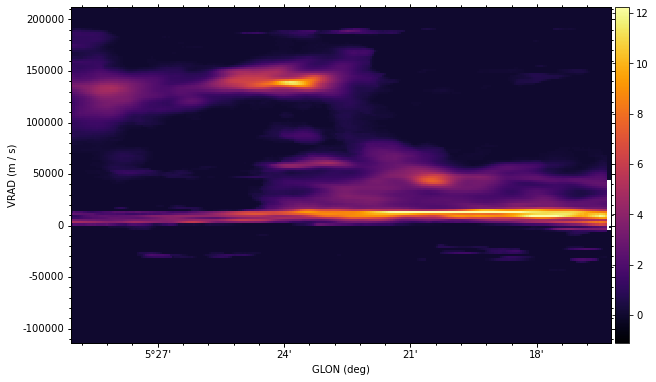

In [46]:
tau_spec_cube_40 = SpectralCube(tau_cube_40, spec_cube_29.wcs)
cu_mean_40 = tau_spec_cube_40.mean(axis=1)
cu_mean_40.quicklook()
cu_mean_40.FITSFigure.show_colorscale(cmap='inferno')

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -9.633e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.070e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.012e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.125e+01 [aplpy.core]


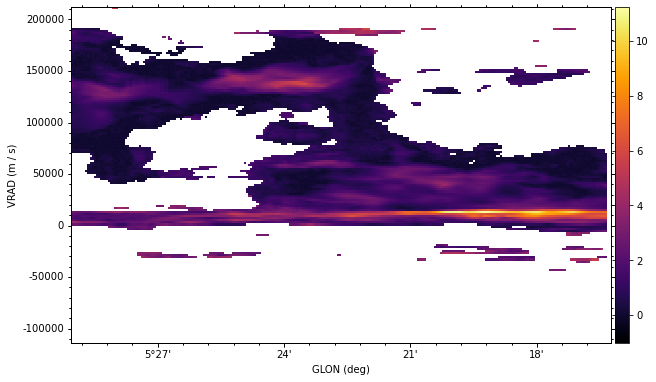

In [47]:
mas_40 = tau_spec_cube_40 < 40 and tau_spec_cube_40 != 0
#mas_40_2 = tau_spec_cube_40 != 0
cu_mean_40 = tau_spec_cube_40.with_mask(mas_40).min(axis=1)
cu_mean_40.quicklook()
cu_mean_40.FITSFigure.show_colorscale(cmap='inferno')

In [48]:
arr_bridge = np.array(tau_spec_cube_40.with_mask(mask_bridge[:, None, :]).with_mask(mas_40).flattened())
arr_G5a = np.array(tau_spec_cube_40.with_mask(mask_G5a[:, None, :]).with_mask(mas_40).flattened())
arr_G5b = np.array(tau_spec_cube_40.with_mask(mask_G5b[:, None, :]).with_mask(mas_40).flattened())
arr_sightline = np.array(tau_spec_cube_40.with_mask(mask_sightline[:, None, :]).with_mask(mas_40).flattened())

arr_bridge[arr_bridge==0] = np.nan
arr_G5a[arr_G5a==0] = np.nan
arr_G5b[arr_G5b==0] = np.nan
arr_sightline[arr_sightline==0] = np.nan

bins = np.geomspace(0.05, 25, num=100)#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        
#plt.hist(arr_bridge[np.isfinite(arr_bridge)], density=True)
counts_bridge, bins_bridge = np.histogram(arr_bridge[np.isfinite(arr_bridge)], bins=bins)
counts_G5a, bins_G5a = np.histogram(arr_G5a[np.isfinite(arr_G5a)], bins=bins)
counts_G5b, bins_G5b = np.histogram(arr_G5b[np.isfinite(arr_G5b)], bins=bins)
counts_sightline, bins_sightline = np.histogram(arr_sightline[np.isfinite(arr_sightline)], bins=bins)

In [49]:
mas_below = tau_spec_cube_40 < 0.05

arr_bridge_ex = np.array(tau_spec_cube_40.with_mask(mask_bridge[:, None, :]).with_mask(mas_40).with_mask(mas_below).flattened())
arr_G5a_ex = np.array(tau_spec_cube_40.with_mask(mask_G5a[:, None, :]).with_mask(mas_40).with_mask(mas_below).flattened())
arr_G5b_ex = np.array(tau_spec_cube_40.with_mask(mask_G5b[:, None, :]).with_mask(mas_40).with_mask(mas_below).flattened())
arr_sightline_ex = np.array(tau_spec_cube_40.with_mask(mask_sightline[:, None, :]).with_mask(mas_40).with_mask(mas_below).flattened())

arr_bridge_ex[arr_bridge_ex==0] = np.nan
arr_G5a_ex[arr_G5a_ex==0] = np.nan
arr_G5b_ex[arr_G5b_ex==0] = np.nan
arr_sightline_ex[arr_sightline_ex==0] = np.nan

bins_ex = np.linspace(0.0, 0.05, num=2)

counts_bridge_ex, bins_bridge_ex = np.histogram(arr_bridge_ex[np.isfinite(arr_bridge_ex)], bins=bins_ex)
counts_G5a_ex, bins_G5a_ex = np.histogram(arr_G5a_ex[np.isfinite(arr_G5a_ex)], bins=bins_ex)
counts_G5b_ex, bins_G5b_ex = np.histogram(arr_G5b_ex[np.isfinite(arr_G5b_ex)], bins=bins_ex)
counts_sightline_ex, bins_sightline_ex = np.histogram(arr_sightline_ex[np.isfinite(arr_sightline_ex)], bins=bins_ex)

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -4.630e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.490e-02 [aplpy.core]


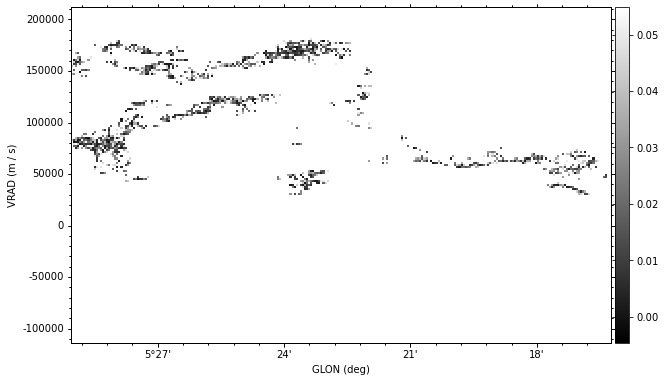

In [50]:
tau_spec_cube_40.with_mask(mas_40).with_mask(mas_below).min(axis=1).quicklook()

In [51]:
bins_ex

array([0.  , 0.05])

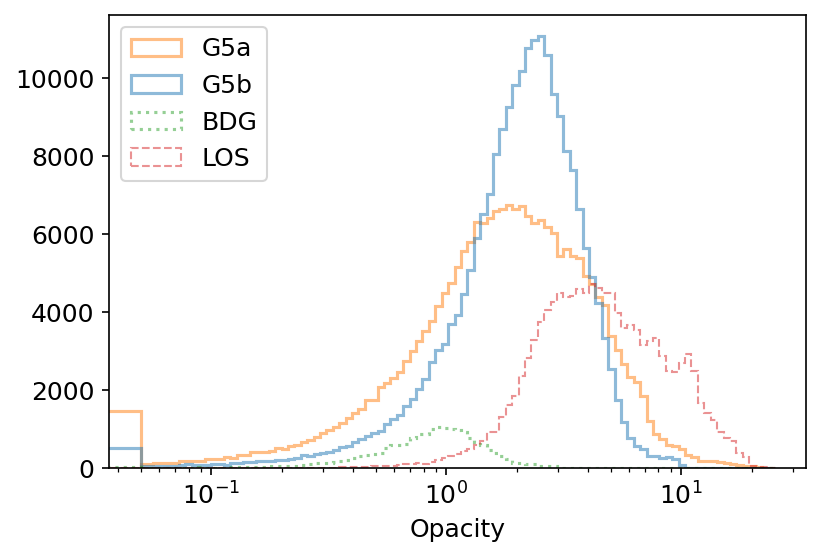

In [52]:
plt.figure(figsize=(6,4),dpi=150)
plt.rcParams.update({'font.size': 12})
plt.hist(bins_G5a[:-1], bins_G5a, alpha=0.5, label='G5a', color='tab:orange', weights=counts_G5a, density=False, histtype='step', linewidth=1.5)
plt.hist(bins_G5b[:-1], bins_G5b, alpha=0.5, label='G5b', color='tab:blue', weights=counts_G5b, density=False, histtype='step', linewidth=1.5)
plt.hist(bins_bridge[:-1], bins_bridge, alpha=0.5, label='BDG', color='tab:green', weights=counts_bridge, density=False, histtype='step', linewidth=1.5, linestyle='dotted')
plt.hist(bins_sightline[:-1], bins_sightline, alpha=0.5, label='LOS', color='tab:red', weights=counts_sightline, density=False, histtype='step', linewidth=1., linestyle='--')
plt.xlabel('Opacity')
#plt.text(3, 0.55, '$^{12}$C/$^{13}$C = 40')

plt.hist(bins_G5a_ex[:-1], bins_G5a_ex, alpha=0.5, color='tab:orange', weights=counts_G5a_ex, density=False, histtype='step', linewidth=1.5)
plt.hist(bins_G5b_ex[:-1], bins_G5b_ex, alpha=0.5, color='tab:blue', weights=counts_G5b_ex, density=False, histtype='step', linewidth=1.5)
plt.hist(bins_bridge_ex[:-1], bins_bridge_ex, alpha=0.5, color='tab:green', weights=counts_bridge_ex, density=False, histtype='step', linewidth=1.5, linestyle='dotted')
plt.hist(bins_sightline_ex[:-1], bins_sightline_ex, alpha=0.5, color='tab:red', weights=counts_sightline_ex, density=False, histtype='step', linewidth=1., linestyle='--')


plt.legend(loc='upper left')
plt.xscale('log')
#plt.yscale('log')
#plt.ylim(0, 0.1)
#plt.xlim(0.000001, 0.1)
#plt.axvline(0.05, color='k', linestyle='--')
#plt.axvline(0.01, color='k', linestyle='--')
#plt.savefig('/orange/adamginsburg/cmz/g5/code/plots/opacity_hist_40.pdf',bbox_inches='tight')

In [53]:
tau_f40(40)

array(-7.55060191e-07)

In [54]:
tau_f40(39.9)

array(0.00513795)

In [55]:
cu_29_LOS = spec_cube_29.with_mask(mas_29_1).with_mask(mas_17_1).with_mask(mask_sightline[:, None, :]).with_mask(mas_40).flattened()
cu_29_G5b = spec_cube_29.with_mask(mas_29_1).with_mask(mas_17_1).with_mask(mask_G5b[:, None, :]).with_mask(mas_40).flattened()
cu_29_G5a = spec_cube_29.with_mask(mas_29_1).with_mask(mas_17_1).with_mask(mask_G5a[:, None, :]).with_mask(mas_40).flattened()
cu_29_bridge = spec_cube_29.with_mask(mas_29_1).with_mask(mas_17_1).with_mask(mask_bridge[:, None, :]).with_mask(mas_40).flattened()

cu_17_LOS = reproj_cube17.with_mask(mas_17_1).with_mask(mas_29_1).with_mask(mask_sightline[:, None, :]).with_mask(mas_40).flattened()
cu_17_G5b = reproj_cube17.with_mask(mas_17_1).with_mask(mas_29_1).with_mask(mask_G5b[:, None, :]).with_mask(mas_40).flattened()
cu_17_G5a = reproj_cube17.with_mask(mas_17_1).with_mask(mas_29_1).with_mask(mask_G5a[:, None, :]).with_mask(mas_40).flattened()
cu_17_bridge = reproj_cube17.with_mask(mas_17_1).with_mask(mas_29_1).with_mask(mask_bridge[:, None, :]).with_mask(mas_40).flattened()

Text(0.5, 0.01, '$^{12}$CO [K]')

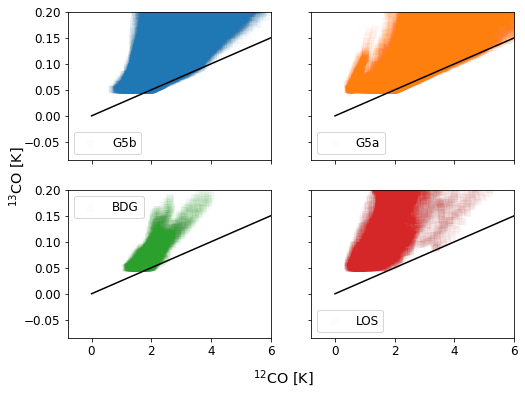

In [56]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(8,6)
axes[0,0].scatter(cu_17_G5b, cu_29_G5b, marker=',', alpha=0.01, label='G5b', color='tab:blue')
axes[0,1].scatter(cu_17_G5a, cu_29_G5a, marker=',', alpha=0.01, label='G5a', color='tab:orange')
axes[1,0].scatter(cu_17_bridge, cu_29_bridge, marker=',', alpha=0.01, label='BDG', color='tab:green')
axes[1,1].scatter(cu_17_LOS, cu_29_LOS, marker=',', alpha=0.01, label='LOS', color='tab:red')

for ax in axes.flatten():
    ax.legend()
    ax.plot(x, y_rat_2, color='k', linestyle='solid')

plt.ylim(top=0.2)
plt.xlim(right=6)
fig.supylabel('$^{13}$CO [K]')
fig.supxlabel('$^{12}$CO [K]')

In [60]:
spec_cube_29.write('/orange/adamginsburg/cmz/g5/code/plots/downsampled_13CO_spw29.fits')

In [61]:
reproj_cube17.write('/orange/adamginsburg/cmz/g5/code/plots/downsampled_12CO_spw17.fits')